# Introduction
We have a data set representing shared bikes rentings according to serveral parameters. 
The objective is to predict the number of bikes rented per hour in the city (variable "count").
Throughout this case study, we will follow the following steps:
- Dataset Presentation
- Some preliminary assumptions and remarks
- Data Cleansing
- Creating and variable extraction
- Statistical analysis
- Prediction models 

Before presenting the data set, here is the list of all used libraries.


In [2]:
# management and data analysis 
import numpy as np
import pandas as pd
from datetime import datetime

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# support for Machine Learning
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# other (math, stat, etc.)
from random import *
from scipy import stats
np.random.seed(91948172)
from copy import deepcopy



# Dataset presentation 

The following lines of code show that the set contains 10886 instances and 12 variables. 
Here is a brief description of these variables:
- __datetime__: date and time of the survey
- __season__: 1 = spring , 2 = summer, 3 = fall, 4 = Winter
- __holiday__: indique si le jour est un jour de vacances scolaires
- __workingday__: indique si le jour est travaillé (ni week-end ni vacances)
- __weather__: 1 = Clear to cloudy, 2 = Clear, 3 = Light rain or snow, 4 = heavy rain or snow
- __temp__: temperature in degrees Celsius
- __atemp__: "feels like" temperature in degrees Celsius
- __humidity__: relative humidity
- __windspeed__: wind speed
- __casual__: number of non-registered user rentals initiated
- __registered__: number of registered user rentals initiated
- __count__: number of total rentals

In [3]:
# read the data set 
df = pd.read_csv("data/data.csv")

In [4]:
# dimensions of dataframe 
df.shape

(10886, 12)

In [5]:
# overview
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# Prior assumptions and remarks

## Variable(s) à prédire
The objective is to predict the number of bikes rented per hour in the city (variable "count"). 
Moreover, we have two variables "casual" and "registered" (which "count" is the sum of).

In [6]:
# check the completeness of the data on the variables to predict 
print((len(df["casual"]) == 10886) 
      and (len(df["registered"]) == 10886) 
      and (len(df["count"]) == 10886))

# check that "count" is the sum of "casual" and "registered" 
print((df["casual"] + df["registered"] == df["count"]).unique())

True
[True]


## Predictors
This step comes ahead of a statistical analysis. 
Here are some factors (in addition to the variables already in the dataset) that could potentially influence the number of rentals:
- "Time": We do not rent the same number of bikes in the middle of the night than in the daytime. This variable can be extracted from the "datetime" variable.
- "Month": Maybe we rent more bikes in sunny days.
- "Year": Maybe there has been a progression or a regression from one year to another. 
- "Weekend": The rental behavior may be different in a weekday and in the weekend. 
- "Traffic": We do not have data on it.
- "Availability of bikes": We do not have data on it. We do not have for example information on the number of people who tried to rent a bike in vain (if indeed such cases arise).


Here are some other preliminary observations:
- "Month" is perhaps more a relevant information that "season".
- the influential variables on "casual" users may not be the same as for "registered" users.


# Data cleaning 
## Missing data
We find, in what follows, that there are no missing data.

In [7]:
# describe the dataframe
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## Data type correction
We will mainly change the types of categorical data that are numerical here.

In [8]:
# information on the data columns, including their types 
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [9]:
# data type transformation to category
df['weather'] = df['weather'].astype('category')
df['holiday'] = df['holiday'].astype('category')
df['workingday'] = df['workingday'].astype('category')
df['season'] = df['season'].astype('category')

# Variable creation
## Mining and preparation of variables 
In the "datetime" column, there is a lot of information. "WorkingDay", "holiday", "season" are already extracted. Here, we extract other information.

In [10]:
# extract the hour 
def getHour(x):
    dt = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    return dt.hour

df['hour'] = df['datetime'].apply(getHour)

In [11]:
# extract the day 
def getDay(x):
    dt = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    return dt.day

df['day'] = df['datetime'].apply(getDay)

In [12]:
# extract the month 
def getMonth(x):
    dt = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    return dt.month

df['month'] = df['datetime'].apply(getMonth)

In [13]:
# extract the year 
def getYear(x):
    dt = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    return dt.year

df['year'] = df['datetime'].apply(getYear)

In [14]:
# extract the day of the week 
# ... 0 for Monday, 6 for Sunday 
def getWeekday(x):
    dt = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    return dt.weekday()

df['weekday'] = df['datetime'].apply(getWeekday)

## Check the data distribution
Before we do the statistical analysis, let us have a look on the data distribution and homogeneity. 
Here are some of our observations:
- the data are homogeneous over 2011 and 2012.
- we have data for the first 19 days of each month
- there are few "missing lines" (you can see the columns of hours are not quite equal).


In [15]:
# data is distributed over the two years 2011 and 2012 
df.groupby('year')['count'].count().reset_index()

,year,count
0,2011,5422
1,2012,5464


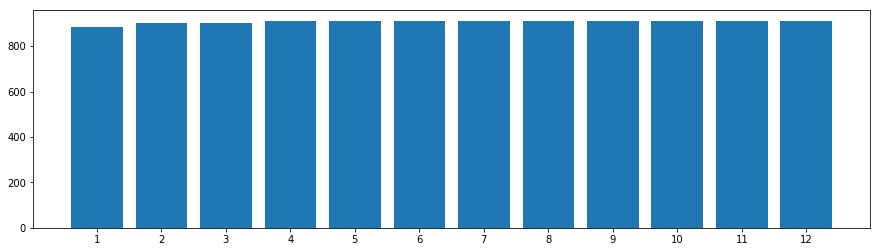

In [16]:
# data is distributed over 12 months
count_groupby_var = df.groupby('month')['count'].count().reset_index()

fig, axs = plt.subplots(1, 1, figsize=(15, 4))
axs.bar(count_groupby_var['month'], count_groupby_var['count'])
axs.set_xticks(count_groupby_var['month'].unique())
plt.show()

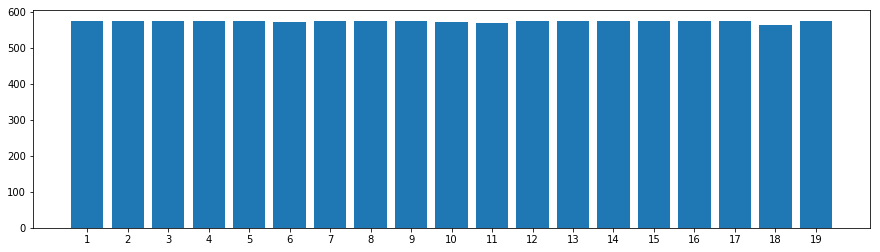

In [17]:
# data is distributed over 19 days
count_groupby_var = df.groupby('day')['count'].count().reset_index()

fig, axs = plt.subplots(1, 1, figsize=(15, 4))
axs.bar(count_groupby_var['day'], count_groupby_var['count'])
axs.set_xticks(count_groupby_var['day'].unique())
plt.show()

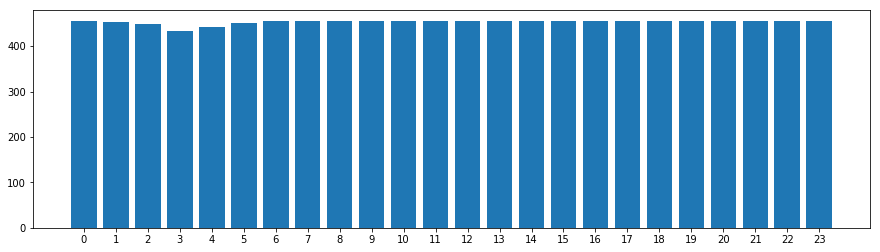

In [18]:
# ata is distributed over 24 hours 
count_groupby_var = df.groupby('hour')['count'].count().reset_index()

fig, axs = plt.subplots(1, 1, figsize=(15, 4))
axs.bar(count_groupby_var['hour'], count_groupby_var['count'])
axs.set_xticks(count_groupby_var['hour'].unique())
plt.show()

# Statistical analysis


We will, throughout this statistical analysis, create functions that will help us visualize the variations of the variables to be predicted and determine the influential factors.


## Analysis of discrete numerical variables 

In [19]:
# function: visualize the change of the dependent variables VS discrete variables
def visualize_by_discr_var(var):

    # means
    casual_by_var = df.groupby(var)['casual'].agg(lambda x: x.mean()).reset_index()
    registered_by_var = df.groupby(var)['registered'].agg(lambda x: x.mean()).reset_index()
    count_by_var = df.groupby(var)['count'].agg(lambda x: x.mean()).reset_index()

    # visualisation
    fig, axes = plt.subplots(2, 3, sharey="row", figsize=(15, 8))
    plt.subplots_adjust(wspace=0.3, hspace=0.3);
    fig.suptitle('')
    
    # ligne 1 
    axt = axes[0, 0]
    axt.plot(casual_by_var[var], casual_by_var['casual'])
    axt.set_title('fig.1 : ' + 'mean_casual_by_' + var)
    axt.grid(True)

    axt = axes[0, 1]
    axt.plot(registered_by_var[var], registered_by_var['registered'])
    axt.set_title('fig.2 : ' + 'mean_registered_by_' + var)
    axt.grid(True)

    axt = axes[0, 2]
    axt.plot(count_by_var[var], count_by_var['count'])
    axt.set_title('fig.3 : ' + 'mean_count_by_' + var)
    axt.grid(True)
    
    # ligne 2 
    axt = axes[1, 0]
    df.boxplot(column='casual', by=var, ax=axes[1, 0])
    axt.set_title('fig.4 : ' + 'casual_by_' + var)
    axt.grid(True)
    axt.get_figure().suptitle('')

    axt = axes[1, 1]
    df.boxplot(column='registered', by=var, ax=axes[1, 1])
    axt.set_title('fig.5 : ' + 'registered_by_' + var)
    axt.grid(True)
    axt.get_figure().suptitle('')

    axt = axes[1, 2]
    df.boxplot(column='count', by=var, ax=axes[1, 2])
    axt.set_title('fig.6 : ' + 'count_by_' + var)
    axt.grid(True)
    axt.get_figure().suptitle('')
    
    plt.show()


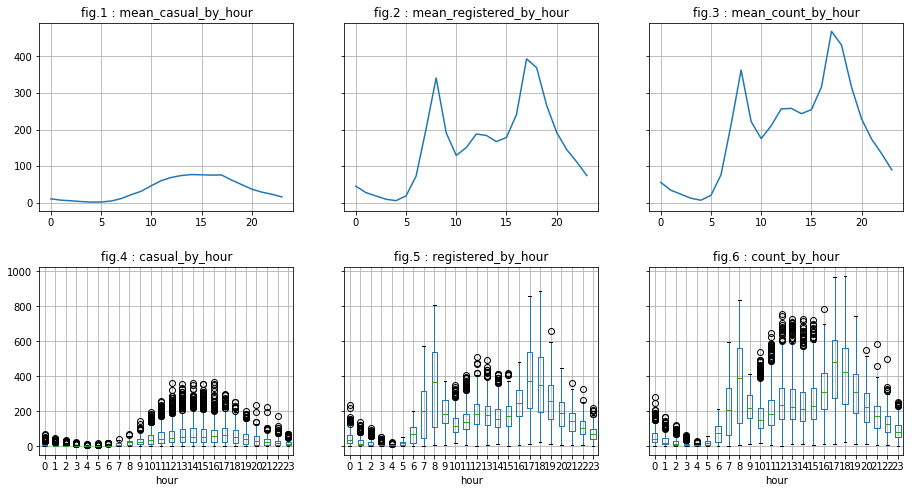

In [20]:
visualize_by_discr_var('hour')

We see two "phenomena":
- With regard to "casual" users, the distribution is as follows: a top peak in mid-afternoon and a down peak in the middle of the night. This may correspond to tourists for example.
- As for "registered" users, they represent the majority of users (visualizations are on the same "y" scale). Moreover, we can say that there is a peak around 5pm, another arount 8 am and, and to a least extent, a small peak arount 12pm or 1pm. This may correspond to workers or students who use the bicycle as means of transportation.

We also notice that we have "outlier". 
However, they are probably "natural outliers". 
To overcome this, we create the logarithms of the dependent variables do the analysis once again.


In [21]:
# creation of logarithms of the dependent variables
df['casual_log'] = np.log(df['casual'] + 1) 
df['registered_log'] = np.log(df['registered'] + 1) 
df['count_log'] = np.log(df['count'] + 1) 


In [22]:
# function: visualize the change in the ... 
# ... log of the dependent variables with regards to discrete variable 
def visualize_log_by_discr_var(var):

    # mean of the dependent variables
    casual_by_var = df.groupby(var)['casual_log'].agg(lambda x: x.mean()).reset_index()
    registered_by_var = df.groupby(var)['registered_log'].agg(lambda x: x.mean()).reset_index()
    count_by_var = df.groupby(var)['count_log'].agg(lambda x: x.mean()).reset_index()

    # visualisation
    fig, axes = plt.subplots(2, 3, sharey="row", figsize=(15, 8))
    plt.subplots_adjust(wspace=0.3, hspace=0.3);
    fig.suptitle('')
    
    # ligne 1 
    axt = axes[0, 0]
    axt.plot(casual_by_var[var], casual_by_var['casual_log'])
    axt.set_title('fig.1 : ' + 'mean_casual_by_' + var)
    axt.grid(True)

    axt = axes[0, 1]
    axt.plot(registered_by_var[var], registered_by_var['registered_log'])
    axt.set_title('fig.2 : ' + 'mean_registered_by_' + var)
    axt.grid(True)

    axt = axes[0, 2]
    axt.plot(count_by_var[var], count_by_var['count_log'])
    axt.set_title('fig.3 : ' + 'mean_count_by_' + var)
    axt.grid(True)
    
    # ligne 2 
    axt = axes[1, 0]
    df.boxplot(column='casual_log', by=var, ax=axes[1, 0])
    axt.set_title('fig.4 : ' + 'casual_by_' + var)
    axt.grid(True)
    axt.get_figure().suptitle('')

    axt = axes[1, 1]
    df.boxplot(column='registered_log', by=var, ax=axes[1, 1])
    axt.set_title('fig.5 : ' + 'registered_by_' + var)
    axt.grid(True)
    axt.get_figure().suptitle('')

    axt = axes[1, 2]
    df.boxplot(column='count_log', by=var, ax=axes[1, 2])
    axt.set_title('fig.6 : ' + 'count_by_' + var)
    axt.grid(True)
    axt.get_figure().suptitle('')
    
    plt.show()


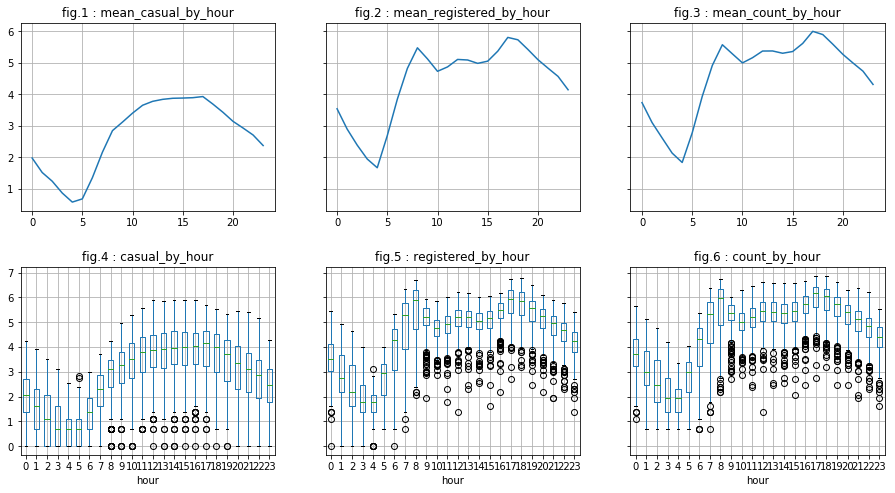

In [23]:
visualize_log_by_discr_var('hour')

There are indeed less outliers regarding "casual" users. However, this is less conclusive regarding "registered" users.
In what follows, we do the same for column "month" and "day". We will see that :
- for "month": It appears visually to be correlated with the dependent variables (peak in june for example). Also, the analysis of log of data seem to minimize the presence of outliers.
- for "day": There does not appear to be a correlation. 


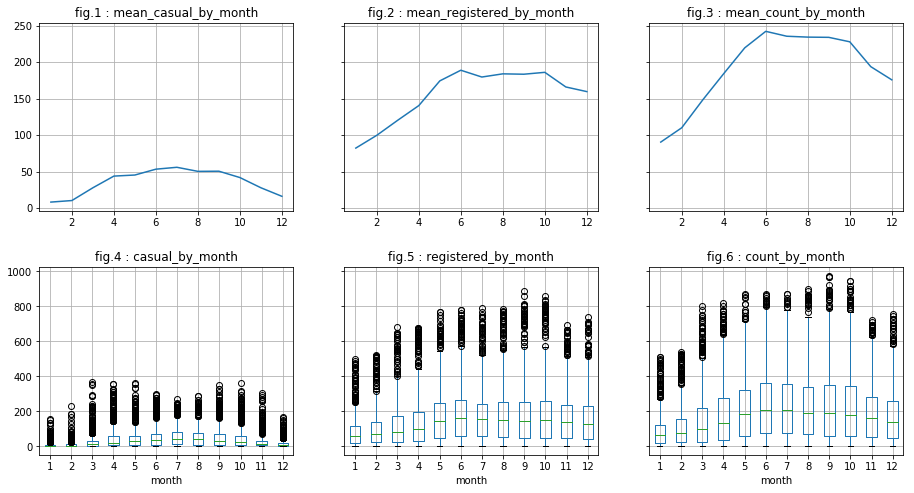

In [24]:
visualize_by_discr_var('month')

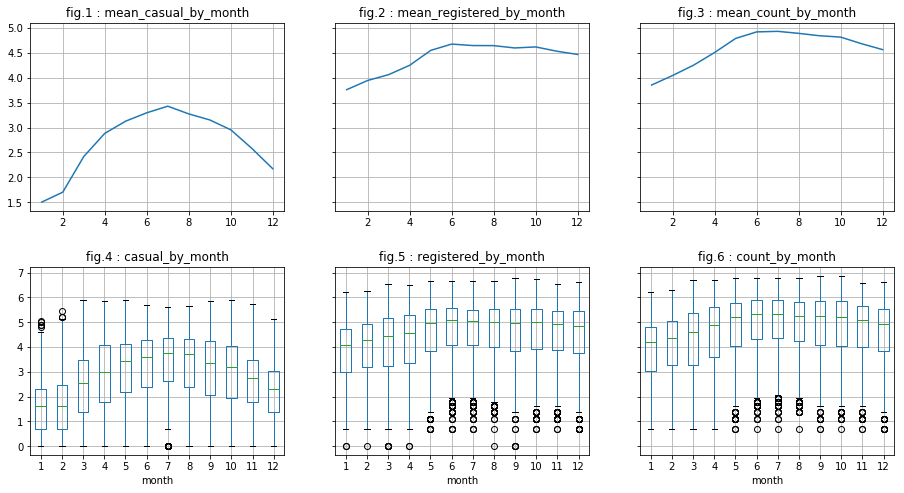

In [25]:
visualize_log_by_discr_var('month')

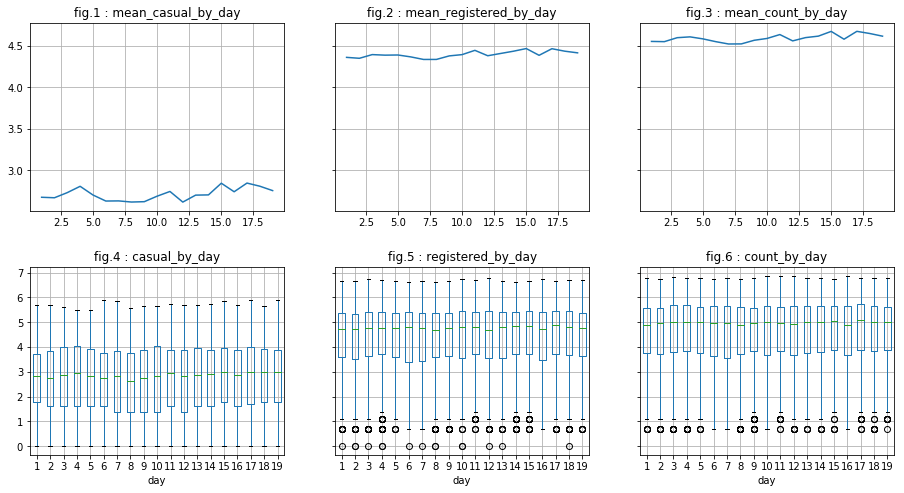

In [26]:
visualize_log_by_discr_var('day')

We observed that the dependent variables depend on the hour and perhaps particularly on working hours. Let us assume that the "behavior" are different in the weekdays, at least for the "registered" user.
We will discover that however that it is true for "registered" and "casual" users.
As the contrast is very clear, we decided to create a variable "is_weekend" to be used instead of "weekday".


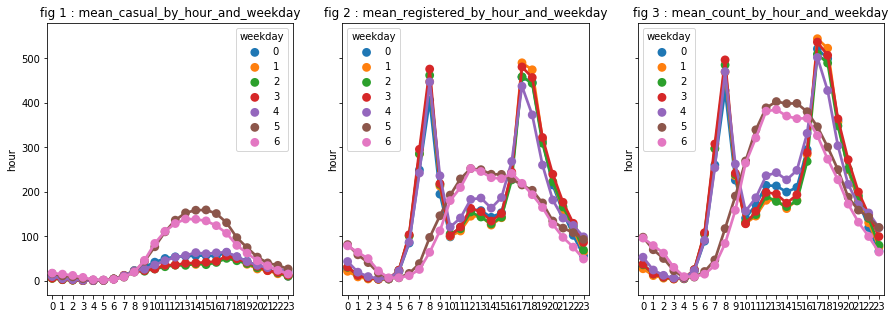

In [27]:
# aggregations of dependent variables based on hours and days of the week 
hour_agg_casual = pd.DataFrame(df.groupby(["hour","weekday"],sort=True)["casual"].mean()).reset_index()
hour_agg_registered = pd.DataFrame(df.groupby(["hour","weekday"],sort=True)["registered"].mean()).reset_index()
hour_agg_count = pd.DataFrame(df.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()

# visualisations 
fig, axes = plt.subplots(1, 3, sharey="row", figsize=(15, 5))

axt = axes[0]
sns.pointplot(x=hour_agg_casual["hour"], y=hour_agg_casual["casual"],
              hue=hour_agg_casual["weekday"], data=hour_agg_casual, join=True, ax=axt)
axt.set(xlabel='', ylabel='hour',title='fig 1 : mean_casual_by_hour_and_weekday')

axt = axes[1]
sns.pointplot(x=hour_agg_registered["hour"], y=hour_agg_registered["registered"],
              hue=hour_agg_registered["weekday"], data=hour_agg_registered, join=True, ax=axt)
axt.set(xlabel='', ylabel='hour',title='fig 2 : mean_registered_by_hour_and_weekday')

axt = axes[2]
sns.pointplot(x=hour_agg_count["hour"], y=hour_agg_count["count"],
              hue=hour_agg_count["weekday"], data=hour_agg_count, join=True, ax=axt)
axt.set(xlabel='', ylabel='hour',title='fig 3 : mean_count_by_hour_and_weekday')

plt.show()

In [28]:
# creation of "is_weekend"
def is_weekend(weekday):   
    return 1 if ((weekday == 5) or (weekday == 6)) else 0

df['is_weekend'] = df['weekday'].apply(is_weekend)

# data type: category
df['is_weekend'] = df['is_weekend'].astype('category')


We turn our attention to the variable year. We notice a phenomenon: there is an increase between 2011 and 2012. We decide to keep this variable. However, are not able to say relevance for future years (since we have only 2 years, it is, indeed, difficult to predict what will be the evolution to year n + 2).


In [29]:
df['year_month'] = df['year'] * 100 + df['month']

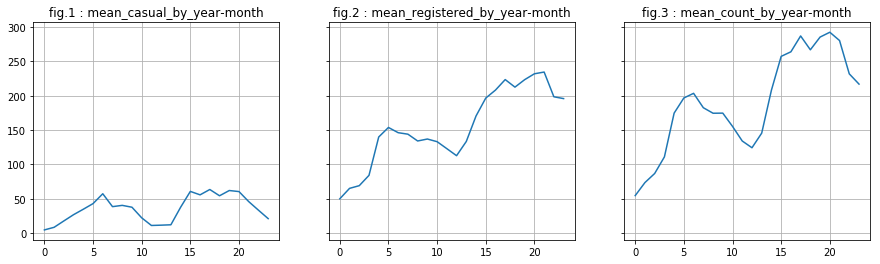

In [30]:
# mean
casual_by_ym = df.groupby('year_month')['casual'].mean().reset_index()
registered_by_ym = df.groupby('year_month')['registered'].mean().reset_index()
count_by_ym = df.groupby('year_month')['count'].mean().reset_index()

# visualisation
fig, axes = plt.subplots(1, 3, sharey="row", figsize=(15, 4))

axt = axes[0]
axt.plot(casual_by_ym['casual'])
axt.set_title('fig.1 : ' + 'mean_casual_by_year-month')
axt.grid(True)

axt = axes[1]
axt.plot(registered_by_ym['registered'])
axt.set_title('fig.2 : ' + 'mean_registered_by_year-month')
axt.grid(True)

axt = axes[2]
axt.plot(count_by_ym['count'])
axt.set_title('fig.3 : ' + 'mean_count_by_year-month')
axt.grid(True)

plt.show()


## Analysis of categorical variables 
We directly observe the distribution of the log of dependent variables. It does not appear that these variables are particularly influential, except "season" on "casual" users. However, we will not keep "season" because we believe that "month" has probably a greater explanatory power.


In [31]:
# function to visualize the change of the ... 
# ... log of dependent variables  
def visualize_log_by_cat_var(var):
    
    # mean
    casual_by_var = df.groupby(var)['casual_log'].agg(lambda x: x.mean()).reset_index()
    registered_by_var = df.groupby(var)['registered_log'].agg(lambda x: x.mean()).reset_index()
    count_by_var = df.groupby(var)['count_log'].agg(lambda x: x.mean()).reset_index()

    # visualisation 
    fig, axes = plt.subplots(1, 3, sharey="row", figsize=(15, 4))
    
    axt = axes[0]
    df.boxplot(column='casual_log', by=var, ax=axes[0])
    axt.set_title('fig 1 : ' + 'casual_log_by_' + var)
    axt.grid(True)
    axt.get_figure().suptitle('')

    axt = axes[1]
    df.boxplot(column='registered_log', by=var, ax=axes[1])
    axt.set_title('fig 2 : ' + 'registered_log_by_' + var)
    axt.grid(True)
    axt.get_figure().suptitle('')

    axt = axes[2]
    df.boxplot(column='count_log', by=var, ax=axes[2])
    axt.set_title('fig 3 : ' + 'count_log_by_' + var)
    axt.grid(True)
    axt.get_figure().suptitle('')
    
    plt.show()


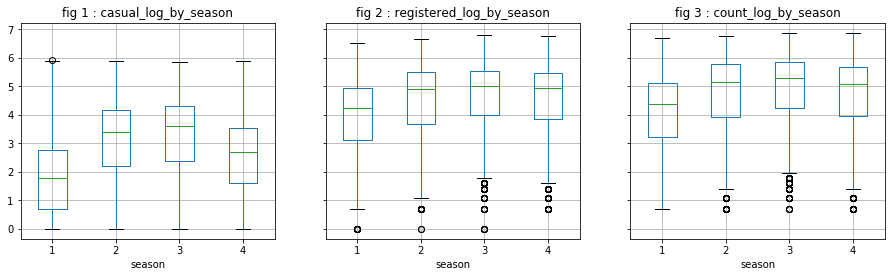

In [32]:
visualize_log_by_cat_var('season')

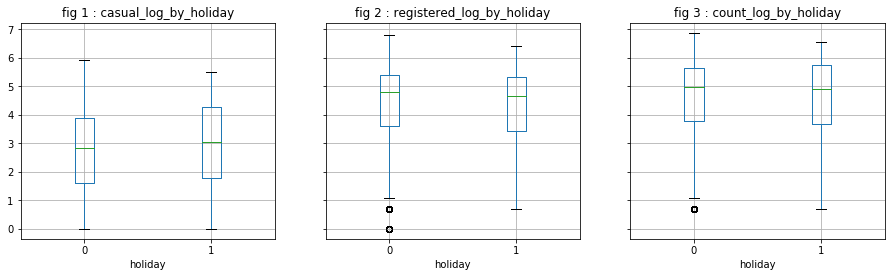

In [33]:
visualize_log_by_cat_var('holiday')

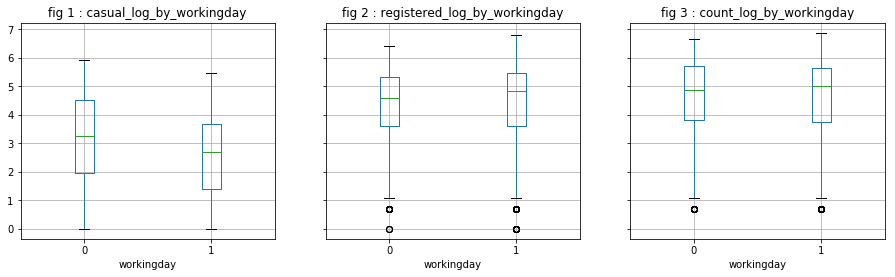

In [34]:
visualize_log_by_cat_var('workingday')

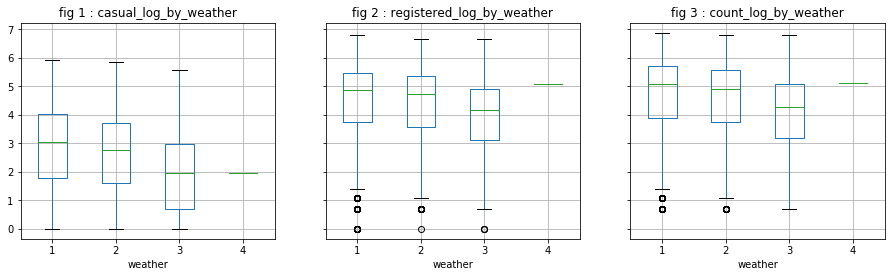

In [35]:
#visualize_log_by_cat_var('weather')

## Analysis of continuous variables 
We first see the correlation matrix. We observe that:
- "Temp" is correlated with "atemp", which is predictable (0.98). This allows us to keep only one of the two variables. "Temp" is correlated with 0.47 and 0.32 respectively to "casual" and "registered".
- "Windspeed" has a low correlation with the dependent variables, which is confirmed by the visualizations.
- "Humidity" is negatively correlated with "casual".


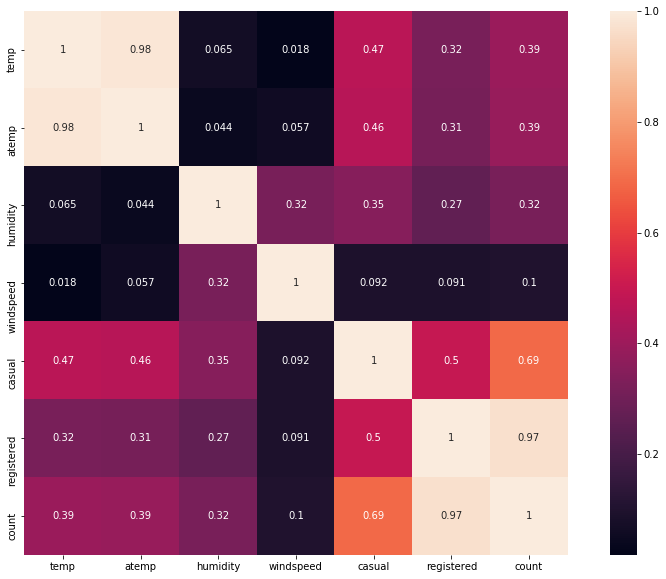

In [36]:
# calculate correlation 
# ... note that we will take the absolute value 
corr_mat = df[["temp","atemp","humidity","windspeed","casual","registered", "count"]].corr()
corr_mat = abs(corr_mat)

fig,ax= plt.subplots()
fig.set_size_inches(15,10)
sns.heatmap(corr_mat, square=True, annot=True)

In [37]:
# function that allows to visualize the variation of the... 
# ... log variables of the dependent variables 
def visualize_by_cont_var(var):
    
    # visualisation des dispersion des log des variables à prédire en fonction de la variable "var"
    f, axarr = plt.subplots(1, 3, sharey=True, figsize=(15, 4))
    
    axarr[0].scatter(df[var], df['casual'], s=1)
    axarr[0].set_title('casual_by_' + var)
    axarr[0].grid(True)

    axarr[1].scatter(df[var], df['registered'], s=1)
    axarr[1].set_title('registered_by_' + var)
    axarr[1].grid(True)

    axarr[2].scatter(df[var], df['count'], s=1)
    axarr[2].set_title('count_by_' + var)
    axarr[2].grid(True)

    plt.show()


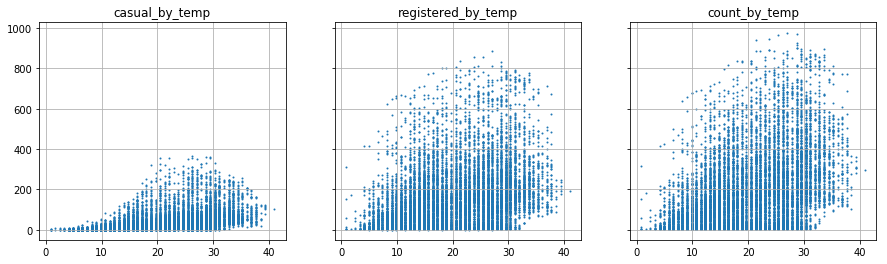

In [38]:
visualize_by_cont_var('temp')

The scatter visualization is not very clear. We decide to categorize the continuous variables.

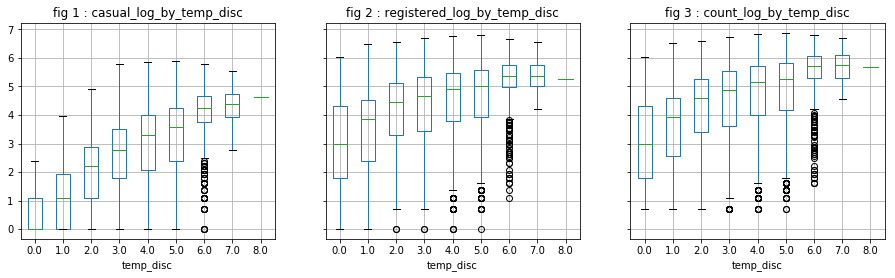

In [39]:
# discretization of the variable "temp"
[df['temp_disc'], mod] = divmod(df['temp'], 5)

visualize_log_by_cat_var('temp_disc')

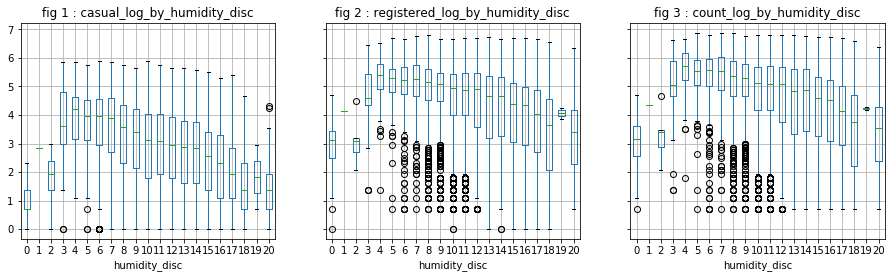

In [40]:
# discretization of the variable "humidity"
[df['humidity_disc'], mod] = divmod(df['humidity'], 5)

visualize_log_by_cat_var('humidity_disc')

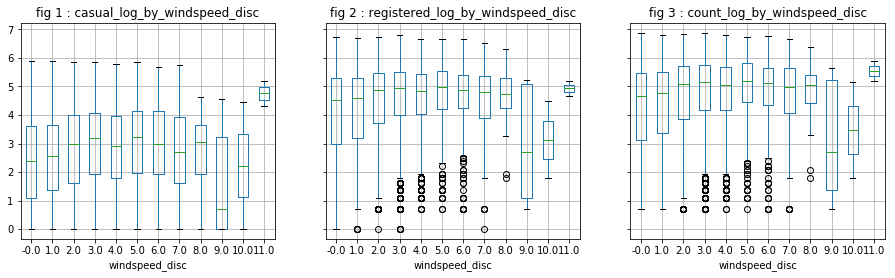

In [41]:
# discretization of the variable "windspeed"
[df['windspeed_disc'], mod] = divmod(df['windspeed'], 5)

visualize_log_by_cat_var('windspeed_disc')

## Complementary question
Assuming we have access to the sex and age of subscribed users, the statistical procedure that would allow us to say whether the age distributions of the two populations (women and men) are identical or not is the "Student test." 

This test has conditions such as:
- number of data by group > 30 or the distribution follows a normal distribution
- equality of variances in each group

Note that if these conditions are not validated, other tests may be applied.

There are two possible outcomes:
- "pvalue" < 0.05: In this case, we consider that the difference is significant between the two distributions.
- "pvalue" > = 0.05: In this case, we consider that the difference was not significant between the two distributions.

Let's take an example. We build a dummy population of 1,000 individuals.
We randomly generate gender and age independently, then we merge the lists as columns. After application of the test, we get a "pvalue" way above the threshold. This result is expected because we generated randomly ages regardless of sexes.


In [42]:
# 1000 "sex" randomly 
sex_list = []
for i in range(1000):
    sex_list.append( choice(["Female", "Male"]) )
    
# 1000 "age" randomly 
age_list = [round(gauss(50,15)) for i in range(1000)]
    
# build a dummy data set on subscribers by combining the two lists 
df_registered = pd.DataFrame({
        "sex": sex_list,
        "age": age_list
    })


In [43]:
# separate the 2 groups 
df_registered_male = df_registered.loc[df_registered["sex"] == "Male",]
df_registered_female = df_registered.loc[df_registered["sex"] == "Female",]

In [44]:
# Student test
stats.ttest_ind(df_registered_male['age'],df_registered_female['age'])

Ttest_indResult(statistic=0.51163904173187325, pvalue=0.6090168396254797)

# Build a prediction model


Given these observations we have made previously, we make the following choices:
- We separately the model training of the "casual" users and the "registered" users. They do not have exactly the same predictor variables. In addition, the predictor variables do not have the same effect on them.
- We will analyze the log of the dependent variable to minimize the presence of outliers.


## Process

To design the two models, here are the steps we shall follow:
- Reserve some of the data to the final performance evaluation (we reserve 20%): df_test

- For the remaining 80%, we do one of the two things:
 - reserve 25% for validation (df_validate) and 75% for training the model (df_train)
 - using cross-validation with a value of 10 k-fold for example. Note that this procedure is more time consuming. However, this is the one we use because it is more accurate in the performance estimation.
- Tune parameters. We will do this step along with cross-validation using "GridSearchCV".
- Choose the model with the best performance.
- Calculate the actual performance using the df_test.
- Build the model again on all data (using the selected model type and with the optimal settings).


## Choice of models

We have selected some models. We will choose the one that will show the best performance with the best settings:
- Linear regression: It is simple and fast, so it costs "nothing" to try. However, it tends to be simplistic, and therefore inefficient. It is also very sensitive to outliers (which we tried to correct by using the log of dependent variables).
- knn regression: It is an effective algorithm when the amount of data is high. It can be time consuming as it is necessary to determine all inter-distances.
- Random Forests: Decision trees, if they are not controlled, tend to overfit. To avoid this, a large number of trees are built. The average of this "forest" is a tree that prevents overfitting. However, random forests tend to be memory time consuming.

Other algorithms can be used and that we do not use here, for example:
- Ridge Regression: It is interesting when the number of dimensions is high, which is not the case here.
- boosted decision trees: They avoid overfitting by limiting the number of possible subdivisions. The algorithm builds a sequence of trees that enables to compensate for the error of the previous trees. As random forests, they also tend to use a lot of memory.

Before training models, let us present the evaluation criterion.

In ordre to evaluate the performance, we will compute the "mean squared error" on log of the dependent variables (thus the "logarithmic mean squared error" on the variables themselves). Other criteria exist such as the "mean absolute error". But we prefer the "logarithmic mean squared error" that penalize bigger errors.


## Model taining
Here we follow the previously described steps.

In [45]:
# reserve 20% of the data for the final test 
df_train, df_test = train_test_split(df, test_size=0.2, random_state=91948172)

# predictor for "casual"
predictors_4_casual = ['hour', 'is_weekend', 'month', 'year', 'temp', 'humidity']
# preparation of the matrix X and the vector y for "casual"
df_train_X_4_casual = df_train[predictors_4_casual]
df_train_y_casual_log = df_train['casual_log']

# predictor for "registered"
predictors_4_registered = ['hour', 'is_weekend', 'month', 'year', 'temp']
# preparation of the matrix X and the vector y for "registered"
df_train_X_4_registered = df_train[predictors_4_registered]
df_train_y_registered_log = df_train['registered_log']

# ...'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
# ...'hour', 'month', 'year', 'day', is_weekend', 


To train the models we use "scikit-learn" 0.19.1 (the latest stable version at the moment of the case study).


In [46]:
# global parameters

# evaluation method 
scoring_param = 'neg_mean_squared_error'

# number of groups for cross-validation
cv_param = 10

In [47]:
# "linear regression" for "casual" 
# note: no cross-validation here since the linear regression does not overfit
model = LinearRegression()

model.fit(df_train_X_4_casual, df_train_y_casual_log)
pred = model.predict(df_train_X_4_casual)
score_value = mean_squared_error(df_train_y_casual_log, pred)
print("MSLE : %0.3f" % (score_value)) 

MSLE : 0.888


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [48]:
# "linear regression" for "registered" 
# note: no cross-validation here since the linear regression does not overfit
model = LinearRegression()

model.fit(df_train_X_4_registered, df_train_y_registered_log)
pred = model.predict(df_train_X_4_registered)
score_value = mean_squared_error(df_train_y_registered_log, pred)
print("MSLE : %0.3f" % (score_value)) 

MSLE : 1.099


In [49]:
# "k nearest 'neighbors" for "casual" 
# note: using GridSearchCV (cross validation and determination of optimal parameters) 
model = KNeighborsRegressor()

hyperparameters = {
    "n_neighbors": range(1,49,10)
}

grid = GridSearchCV(model, param_grid=hyperparameters, cv=cv_param, scoring=scoring_param)
grid.fit(df_train_X_4_casual, df_train_y_casual_log)

print(grid.best_params_)
print("MSLE : %0.3f" % (grid.best_score_)) 

{'n_neighbors': 11}
MSLE : -0.505


In [50]:
# "k nearest 'neighbors" for "registered" 
# note: using GridSearchCV (cross validation and determination of optimal parameters) 
model = KNeighborsRegressor()

hyperparameters = {
    "n_neighbors": range(1,49,10)
}

grid = GridSearchCV(model, param_grid=hyperparameters, cv=cv_param, scoring=scoring_param)
grid.fit(df_train_X_4_registered, df_train_y_registered_log)

print(grid.best_params_)
print("MSLE : %0.3f" % (grid.best_score_)) 

{'n_neighbors': 11}
MSLE : -0.244


In [51]:
# "random forest" for "casual" 
# note: we use here cross validation and empirical determination of the parameters 
# ... GridSearchCV is too greedy here 
model = RandomForestRegressor(n_estimators=120, min_samples_split=10, min_samples_leaf=5)

scores = cross_val_score(model, df_train_X_4_casual, df_train_y_casual_log, cv=cv_param, scoring=scoring_param)
print("MSLE : %0.3f" % (scores.mean())) 

MSLE : -0.277


In [52]:
# random forest" for "registered"
# note: we use here cross validation and empirical determination of the parameters 
# ... GridSearchCV is too greedy here 
model = RandomForestRegressor(n_estimators=90, min_samples_split=10, min_samples_leaf=5)

scores = cross_val_score(model, df_train_X_4_registered, df_train_y_registered_log, cv=cv_param, scoring=scoring_param)
print("MSLE : %0.3f" % (scores.mean())) 

MSLE : -0.143


## Choosing the type of model and parameters
Here are our picks:
- As for predicting the locations for the variable "casual", we choose the "RandomForestRegressor" with the following parameters: n_estimators = 120, min_samples_split = 10 = 5 min_samples_leaf.
- As for predicting the locations for the variable "registered", we choose the "RandomForestRegressor" with the following parameters: n_estimators = 90, = 10 min_samples_split, min_samples_leaf = 5.

## Final evaluation 
We use the model with the best performance to evaluate the test data (that the model has not "seen"). We will see that the performances are not very different from those already obtained. This may indicate that we do not need additional data (without having to compare learning curves). However, if the predictions have to be done at moments outside of the study interval, the same permformances are not guaranteed.


In [53]:
# casual: test data 
df_test_X_4_casual = df_test[predictors_4_casual]
df_test_y_casual_log = df_test['casual_log']

# casual: reconstruction of the best model on the training data 
model_casual = RandomForestRegressor(n_estimators=120, min_samples_split=10, min_samples_leaf=5)
model_casual.fit(df_train_X_4_casual, df_train_y_casual_log)

# casual: final evaluation 
pred_casual = model_casual.predict(df_test_X_4_casual)
msle = mean_squared_error(df_test_y_casual_log, pred_casual)
print("MSLE : %0.3f" % (msle)) 

MSLE : 0.286


In [54]:
# registered: test data 
df_test_X_4_registered = df_test[predictors_4_registered]
df_test_y_registered_log = df_test['registered_log']

# registered: reconstruction of the best model on the training data 
model_registered = RandomForestRegressor(n_estimators=90, min_samples_split=10, min_samples_leaf=5)
model_registered.fit(df_train_X_4_registered, df_train_y_registered_log)

# registered: final evaluation 
pred_registered = model_registered.predict(df_test_X_4_registered)
msle = mean_squared_error(df_test_y_registered_log, pred_registered)
print("MSLE : %0.3f" % (msle)) 

MSLE : 0.151


## Final model
Let us train one last time the type of model that had the best performance (with the optimal settings). This time, we do it on all the data.


In [55]:
# casual: all data 
df_X_4_casual = df[predictors_4_casual]
df_y_casual_log = df['casual_log']

# casual: build once again and finally the model on all data
model_casual = RandomForestRegressor(n_estimators=120, min_samples_split=10, min_samples_leaf=5)
model_casual.fit(df_X_4_casual, df_y_casual_log)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [56]:
# registered: all data 
df_X_4_registered = df[predictors_4_registered]
df_y_registered_log = df['registered_log']

# registered: build once again and finally the model on all data
model_registered = RandomForestRegressor(n_estimators=90, min_samples_split=10, min_samples_leaf=5)
model_registered.fit(df_X_4_registered, df_y_registered_log)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Let us show how to predict "count" for new data.
Note that we should not forget that the changes we have applied on our current datasets will also have to be applied on the new set.

Here is an example of how we would proceed with a dummy dataset "df_new" (which is a copy of some of the data we already have).


In [57]:
# let us take as an example a sample of 100 rows among the available dataset 
df_new = deepcopy(df.iloc[sample(range(len(df)), 100)])

In [58]:
# casual: extraction of the matrix of predictors 
df_new_X_4_casual = df_new[predictors_4_casual]

# model application
pred_casual = model_casual.predict(df_new_X_4_casual)

# data transformation (inverse of the previously applied log transformation)
df_new['casual'] = np.exp(pred_casual) - 1

In [59]:
# registered: extraction of the matrix of predictors 
df_new_X_4_registered = df_new[predictors_4_registered]

# model application
pred_registered = model_registered.predict(df_new_X_4_registered)

# data transformation (inverse of the previously applied log transformation)
df_new['registered'] = np.exp(pred_casual) - 1

In [60]:
# finally addition of two variables in order to predict "count" 
df_new['count'] = df_new['casual'] + df_new['registered']

# Outlooks

Here are some areas for improvement:
- Consider the "flow". Indeed, the models that have been trained do not consider the "sequence" in data. For example, if at any time, ther is a peak in rentings, maybe the next hour, there will be relatively less rentings compared to the previous day, with the same conditions. It would be interesting to build a model that takes this into account.
- Understand why there has been an increase from one year to the another. For this, we could try to get more data from before 2011 or after 2012 to check the annual increase in rentals. Moreover, it would be interesting to understand what could have caused this increase: lower prices? increasing the number of workers or tourists? responsible user behavior? increased traffic?
- Test other Machine Learning methods such as Polynomial regression, Perceptron or "GradientBoostingRegressor" which seems to show very good performance over a wide range of problems.
